This kernel forked from https://www.kaggle.com/srisudheera/introduction-to-recommendation and got many many insights from following links. If you find this kernel helpful. please do give some credits. Thanks!
1. https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
1. https://www.tuicool.com/articles/biYvArn
1. http://cis.csuohio.edu/~sschung/CIS660/CollaborativeFilteringSuhua.pdf


The original kernel use graphlabs which have been bought by Apple and now it becomes open source project call Turicreate, so i use Turicreate here.


First let's load the data and do some data exploring analysis.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

['ml-100k']
ml-100k



In [2]:
# 1. User's Dataset
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../input/ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1', parse_dates=True) 
# 2. Rating dataset
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../input/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# 3.Movies Dataset
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url','unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../input/ml-100k/u.item', sep='|', names=m_cols,
                     encoding='latin-1')

In [3]:
#users
print(users.shape)
users.head(4)

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537


In [4]:
#ratings
print(ratings.shape)
ratings.head(4)

(100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923


In [5]:
#items
print(movies.shape)
movies.head(4)

(1682, 24)


,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [6]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_train = pd.read_csv('../input/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('../input/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')
ratings_train.shape, ratings_test.shape

((90570, 4), (9430, 4))

In [7]:
ratings_train.head(4),ratings_test.head(4)

(   user_id  movie_id  rating  unix_timestamp
 0        1         1       5       874965758
 1        1         2       3       876893171
 2        1         3       4       878542960
 3        1         4       3       876893119,
    user_id  movie_id  rating  unix_timestamp
 0        1        20       4       887431883
 1        1        33       4       878542699
 2        1        61       4       878542420
 3        1       117       3       874965739)

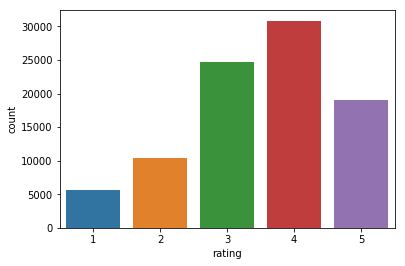

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x=ratings_train.rating,data=ratings_train)

In [9]:
ratings_train.groupby(by='movie_id')['rating'].mean().sort_values(ascending=False).head(20)

movie_id
1500    5.000000
1293    5.000000
1122    5.000000
1189    5.000000
1656    5.000000
1201    5.000000
1599    5.000000
814     5.000000
1467    5.000000
1536    5.000000
1449    4.714286
1642    4.500000
1463    4.500000
1594    4.500000
1398    4.500000
114     4.491525
408     4.480769
169     4.476636
318     4.475836
483     4.459821
Name: rating, dtype: float64

In [10]:
no_of_rated_movies_per_user = ratings_train.groupby(by='user_id')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head()

user_id
405    727
655    675
13     626
450    530
276    508
Name: rating, dtype: int64

Looking PDF and CDF of number of rated movies per user

**CDF**: cummulative denisty function. It is the total probability of anything below it. Its range is 0-1. Also known as density function. Represented as F(x).

**PDF** : Probability denisty function. It is probability at one point. also know as probability mass function(PMF). Represented as f(x).
![1](https://qph.ec.quoracdn.net/main-qimg-e50787cd6024e1945ef5632192b70a69)
[2](http://work.thaslwanter.at/Stats/html/statsDistributions.html)
So both F(x) and f(x) as inter related to each other.
if we do the derivative of F(x) we get the f(x) and vice versa if we integrate f(x) we get the F(x).

**In detail Explaination:**
Generally Random variables are two types 

1.** Continuos**: Which is solved by integral.
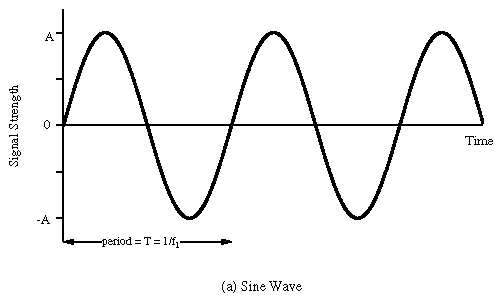  
2.** Discrete** : Which is solved by summation.

So we can say the *PDF* is the continuous function.

[For more Explanation please refer this vedio](http://youtu.be/DIsZFAV9Hy0)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


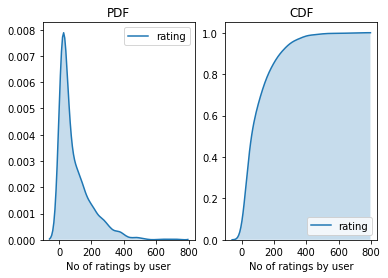

In [11]:
ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [12]:
no_of_rated_movies_per_user.describe()

count    943.000000
mean      96.044539
std      100.931743
min       10.000000
25%       23.000000
50%       55.000000
75%      138.000000
max      727.000000
Name: rating, dtype: float64

In [13]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
quantiles

0.00     10
0.01     10
0.02     10
0.03     10
0.04     11
0.05     11
0.06     12
0.07     12
0.08     12
0.09     13
0.10     13
0.11     14
0.12     14
0.13     15
0.14     15
0.15     16
0.16     16
0.17     17
0.18     17
0.19     18
0.20     19
0.21     19
0.22     20
0.23     21
0.24     22
0.25     23
0.26     23
0.27     25
0.28     25
0.29     27
       ... 
0.71    123
0.72    126
0.73    130
0.74    135
0.75    138
0.76    140
0.77    145
0.78    150
0.79    156
0.80    162
0.81    171
0.82    174
0.83    179
0.84    187
0.85    196
0.86    205
0.87    211
0.88    218
0.89    226
0.90    235
0.91    252
0.92    263
0.93    270
0.94    284
0.95    301
0.96    318
0.97    350
0.98    378
0.99    438
1.00    727
Name: rating, Length: 101, dtype: int64

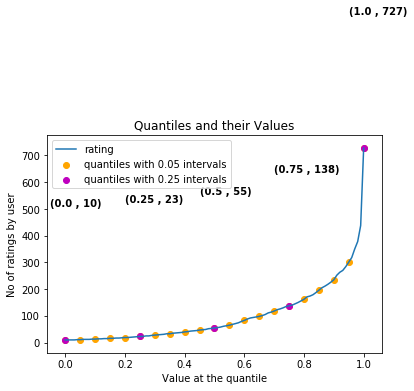

In [14]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')

plt.show()

In [15]:
quantiles[::5]

0.00     10
0.05     11
0.10     13
0.15     16
0.20     19
0.25     23
0.30     28
0.35     33
0.40     40
0.45     47
0.50     55
0.55     65
0.60     83
0.65     98
0.70    118
0.75    138
0.80    162
0.85    196
0.90    235
0.95    301
1.00    727
Name: rating, dtype: int64

In [16]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 301)) )


 No of ratings at last 5 percentile : 48



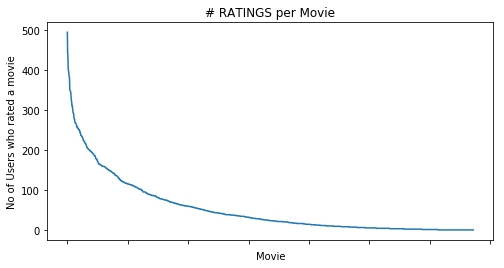

In [17]:
no_of_ratings_per_movie = ratings_train.groupby(by='movie_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

### Building collaborative filtering model from scratch

In [18]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

In [19]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_items))
for line in ratings_test.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [20]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity 

#user_similarity = pairwise_distances(data_matrix, metric='cosine')
#item_similarity = pairwise_distances(data_matrix.T, metric='cosine')
#print (user_similarity[0][1])

# NOTE: why use pairwise_distances? why not cosine_similarity? cosine_distance = 1-cosine_similarity. i believe cosine_similarity is right for here.
# let's change it to consine_similarity

user_similarity = cosine_similarity(data_matrix)
item_similarity = cosine_similarity(data_matrix.T)
print (user_similarity[0][1])


0.16693098386870198


In [21]:
user_similarity.shape

(943, 943)

use following formula to calculate prediction:
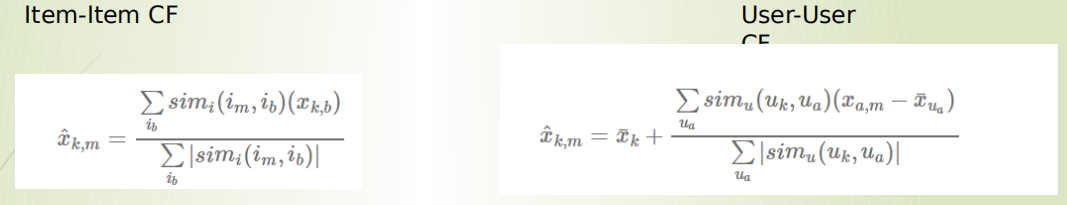

refer to http://cis.csuohio.edu/~sschung/CIS660/CollaborativeFilteringSuhua.pdf

In [22]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        print (mean_user_rating.shape)
        print (mean_user_rating[:, np.newaxis].shape)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])

        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
        print (np.array([np.abs(similarity).sum(axis=1)]).shape, pred.shape)
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [23]:
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')
print (data_matrix[0])
print (user_prediction[0])

(943,)
(943, 1)
(1, 943) (943, 1682)
[5. 3. 4. ... 0. 0. 0.]
[2.69523211 1.02855273 0.71474438 ... 0.27084883 0.27682149 0.27767246]


In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #print (prediction.shape, ground_truth.shape)
    return sqrt(mean_squared_error(prediction, ground_truth))

In [25]:
print ('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print ('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 2.7987250835799276
Item-based CF RMSE: 3.3099173898580325


### Building a simple popularity and collaborative filtering model using Turicreate

In [26]:
import turicreate

train_data = turicreate.SFrame(ratings_train)
test_data = turicreate.SFrame(ratings_test)

In [27]:
popularity_model = turicreate.popularity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating')

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.08627s

90570 observations to process; with 1680 unique items.

In [28]:
#Get recommendations for first 5 users and print them
#users = range(1,6) specifies user ID of first 5 users
#k=5 specifies top 5 recommendations to be given
popularity_recomm = popularity_model.recommend(users=list(range(1,6)),k=5)
popularity_recomm.print_rows(num_rows=25)


+---------+----------+-------+------+
| user_id | movie_id | score | rank |
+---------+----------+-------+------+
|    1    |   1599   |  5.0  |  1   |
|    1    |   1201   |  5.0  |  2   |
|    1    |   1189   |  5.0  |  3   |
|    1    |   1122   |  5.0  |  4   |
|    1    |   814    |  5.0  |  5   |
|    2    |   1599   |  5.0  |  1   |
|    2    |   1201   |  5.0  |  2   |
|    2    |   1189   |  5.0  |  3   |
|    2    |   1122   |  5.0  |  4   |
|    2    |   814    |  5.0  |  5   |
|    3    |   1599   |  5.0  |  1   |
|    3    |   1201   |  5.0  |  2   |
|    3    |   1189   |  5.0  |  3   |
|    3    |   1122   |  5.0  |  4   |
|    3    |   814    |  5.0  |  5   |
|    4    |   1599   |  5.0  |  1   |
|    4    |   1201   |  5.0  |  2   |
|    4    |   1189   |  5.0  |  3   |
|    4    |   1122   |  5.0  |  4   |
|    4    |   814    |  5.0  |  5   |
|    5    |   1599   |  5.0  |  1   |
|    5    |   1201   |  5.0  |  2   |
|    5    |   1189   |  5.0  |  3   |
|    5    | 

In [29]:
#Train Model
#item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating', similarity_type='pearson')
item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating', similarity_type='cosine')

#Make Recommendations:
item_sim_recomm = item_sim_model.recommend(users=list(range(1,6)),k=5)
item_sim_recomm.print_rows(num_rows=25)

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.082909s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 81.451ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 89.354ms                            | 0.25             | 6               |

| 288.621ms                           | 100              | 1680            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.30021s

+---------+----------+--------------------+------+
| user_id | movie_id |       score        | rank |
+---------+----------+--------------------+------+
|    1    |   423    | 0.980611449434557  |  1   |
|    1    |   202    | 0.9633960207455031 |  2   |
|    1    |   655    | 0.8416029747205837 |  3   |
|    1    |   403    | 0.7724758268312644 |  4   |
|    1    |   568    | 0.7718456403444741 |  5   |
|    2    |    50    | 1.1256258487701416 |  1   |
|    2    |   181    | 1.0382135510444641 |  2   |
|    2    |    7     | 0.9083804969604199 |  3   |
|    2    |   121    | 0.8954406735988764 |  4   |
|    2    |    9     | 0.8729543628600928 |  5   |
|    3    |   313    | 0.6165961216796528 |  1   |
|    3    |   328    | 0.5852612771771171 |  2   |
|    3    |   315    | 0.5422587123784152 |  3   |
|    3    |   331    | 0.5355071858926252 |  4   |
|    3    |   332    | 0.5316696112806146 |  5   |
|    4    |    50    | 1.1311477082116264 |  1   |
|    4    |   288    | 1.048715

In [30]:
popularity_model.evaluate(test_data)
item_sim_model.evaluate(test_data)


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.0021208907741251345  | 0.0002120890774125135 |
|   2    | 0.0010604453870625672  | 0.0002120890774125135 |
|   3    | 0.0007069635913750444  | 0.0002120890774125135 |
|   4    | 0.0005302226935312836  | 0.0002120890774125135 |
|   5    |  0.000424178154825027  | 0.0002120890774125135 |
|   6    | 0.0003534817956875222  | 0.0002120890774125135 |
|   7    | 0.0003029843963035903  | 0.0002120890774125135 |
|   8    | 0.0002651113467656418  | 0.0002120890774125135 |
|   9    | 0.00023565453045834795 | 0.0002120890774125135 |
|   10   | 0.0002120890774125135  | 0.0002120890774125135 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0417647969439832

Per User RMSE (best)
+---------+-------------------

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 16974
 
 Data:
 +---------+--------+---------------------+--------+-------+
 | user_id | cutoff |      precision      | recall | count |
 +---------+--------+---------------------+--------+-------+
 |    1    |   1    |         0.0         |  0.0   |   10  |
 |    1    |   2    |         0.5         |  0.1   |   10  |
 |    1    |   3    |  0.3333333333333333 |  0.1   |   10  |
 |    1    |   4    |         0.25        |  0.1   |   10  |
 |    1    |   5    |         0.2         |  0.1   |   10  |
 |    1    |   6    | 0.16666666666666666 |  0.1   |   10  |
 |    1    |   7    |  0.2857142857142857 |  0.2   |   10  |
 |    1    |   8    |         0.25        |  0.2   |   10  |
 |    1    |   9    |  0.2222222222222222 |  0.2   |   10  |
 |    1    |   10   |         0.2         |  0.2   |   10  |
 +---------+--------+---------------------+--------+-------+
 [16974 rows

In [31]:
#model_performance = turicreate.compare(test_data, [popularity_model, item_sim_model])
#turicreate.show_comparison(model_performance,[popularity_model, item_sim_model])
model_performance = turicreate.recommender.util.compare_models = (test_data, [popularity_model, item_sim_model])
print (model_performance)


(Columns:
	user_id	int
	movie_id	int
	rating	int
	unix_timestamp	int

Rows: 9430

Data:
+---------+----------+--------+----------------+
| user_id | movie_id | rating | unix_timestamp |
+---------+----------+--------+----------------+
|    1    |    20    |   4    |   887431883    |
|    1    |    33    |   4    |   878542699    |
|    1    |    61    |   4    |   878542420    |
|    1    |   117    |   3    |   874965739    |
|    1    |   155    |   2    |   878542201    |
|    1    |   160    |   4    |   875072547    |
|    1    |   171    |   5    |   889751711    |
|    1    |   189    |   3    |   888732928    |
|    1    |   202    |   5    |   875072442    |
|    1    |   265    |   4    |   878542441    |
+---------+----------+--------+----------------+
[9430 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., [Class                            : PopularityRecommender

Schema
------


### Model-based Collaborative Filtering

Let’s calculate the sparsity level of MovieLens dataset:


In [32]:
print (len(ratings_train), float(n_users*n_items))
sparsity=round(1.0-len(ratings_train)/float(n_users*n_items),3)
print ('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

90570 1586126.0
The sparsity level of MovieLens100K is 94.3%


in python:

In [33]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

def SVD(rating_matrix):
    #get SVD components from train matrix. Choose k.
    u, s, vt = svds(rating_matrix, k = 20)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    return X_pred

print ('User-based CF MSE: ' + str(rmse(SVD(data_matrix), test_data_matrix)))

User-based CF MSE: 2.424744265287439


in turicreate:

In [34]:
factorization_model = turicreate.factorization_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating')
factorization_recomm = factorization_model.recommend(users=list(range(1,6)),k=5)
factorization_recomm.print_rows(num_rows=25)

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.144774s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11321 / 90570 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.199834                                 |

| 4       | 0.130208          | 0.419463                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.260417          | 0.199834                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 1.268             | 1.12606               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.41ms      | 1.42844           | 1.19517               | 0.260417    |

| 2       | 116.438ms    | 0.871143          | 0.933344              | 0.260417    |

| 3       | 168.132ms    | 0.800583          | 0.894746              | 0.260417    |

| 4       | 215.946ms    | 0.765389          | 0.874857              | 0.260417    |

| 5       | 271.367ms    | 0.743878          | 0.862475              | 0.260417    |

| 10      | 518.733ms    | 0.668646          | 0.817695              | 0.260417    |

| 50      | 2.53s        | 0.556977          | 0.746283              | 0.260417    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.535584

Final training RMSE: 0.73181

+---------+----------+--------------------+------+
| user_id | movie_id |       score        | rank |
+---------+----------+--------------------+------+
|    1    |   718    | 5.178422532424026  |  1   |
|    1    |   408    | 5.041959724768692  |  2   |
|    1    |   647    | 4.973559401377731  |  3   |
|    1    |   1449   | 4.952143392905288  |  4   |
|    1    |   896    | 4.939109138592773  |  5   |
|    2    |   1449   | 4.932576946362548  |  1   |
|    2    |   180    | 4.877814091190391  |  2   |
|    2    |   187    | 4.841799653514915  |  3   |
|    2    |   480    | 4.837975315197998  |  4   |
|    2    |   357    | 4.7989096561518245 |  5   |
|    3    |    19    | 5.926108337387138  |  1   |
|    3    |   1368   | 5.713348604187065  |  2   |
|    3    |   647    | 5.530661977275901  |  3   |
|    3    |   1512   | 5.516597933515602  |  4   |
|    3    |   1126   | 5.506409622177177  |  5   |
|    4    |   1022   | 6.541613853916221  |  1   |
|    4    |   320    | 6.534536

In [35]:
factorization_model.evaluate(test_data)


Precision and recall summary statistics by cutoff
+--------+----------------------+-----------------------+
| cutoff |    mean_precision    |      mean_recall      |
+--------+----------------------+-----------------------+
|   1    | 0.03075291622481441  | 0.0030752916224814444 |
|   2    | 0.02598091198303289  |  0.005196182396606572 |
|   3    | 0.023329798515376483 |  0.006998939554612942 |
|   4    | 0.02439024390243904  |  0.009756097560975611 |
|   5    | 0.024178154825026485 |  0.012089077412513242 |
|   6    | 0.02456698480028279  |  0.014740190880169679 |
|   7    | 0.02363278291168005  |  0.016542948038176044 |
|   8    | 0.023727465535524926 |  0.018981972428419955 |
|   9    | 0.023329798515376435 |  0.020996818663838797 |
|   10   | 0.022481442205726433 |  0.022481442205726433 |
+--------+----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0285461080759564

Per User RMSE (best)
+---------+---------------------+-------+
| user_id |     

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 16974
 
 Data:
 +---------+--------+-----------+--------+-------+
 | user_id | cutoff | precision | recall | count |
 +---------+--------+-----------+--------+-------+
 |    1    |   1    |    0.0    |  0.0   |   10  |
 |    1    |   2    |    0.0    |  0.0   |   10  |
 |    1    |   3    |    0.0    |  0.0   |   10  |
 |    1    |   4    |    0.0    |  0.0   |   10  |
 |    1    |   5    |    0.0    |  0.0   |   10  |
 |    1    |   6    |    0.0    |  0.0   |   10  |
 |    1    |   7    |    0.0    |  0.0   |   10  |
 |    1    |   8    |    0.0    |  0.0   |   10  |
 |    1    |   9    |    0.0    |  0.0   |   10  |
 |    1    |   10   |    0.0    |  0.0   |   10  |
 +---------+--------+-----------+--------+-------+
 [16974 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and colum